In [6]:
from src.distance_measures import analyse_video, analyse_image
from src.gaussian_noise import generate_noise_array, generate_noise
from src.preprocessing import process_image, process_video
from src.gradient_descent import find_default_params
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from tqdm import tqdm

In [7]:
size = 300
skip_size=60
L=50
im_thresh = 0.3
noise_thresh = 0.2
smooth = 2.4
# prior_thresh = 0.2
# prior_smooth = 2.4

In [8]:
im = process_video('images/cheese_gel.avi', threshold=im_thresh, size=size, skip_size=skip_size)

In [9]:
def model(thresh, smooth):
    noise = generate_noise_array(size=size, threshold=thresh, smooth=smooth, amount=2)
    F, G = analyse_video(noise, L=50)
    return np.mean([i / j for i, j in zip(F, G)], axis=0)

def loss_fn(y, thresh, smooth, pthresh, psmooth, w):
    return np.sum((model(thresh, smooth) - y)**2) + w*((thresh - pthresh)**2 + 0.5*(smooth - psmooth)**2)

In [10]:
max_iter = 50
h = 0.01
learning_rate = 0.01
#w_list= [5, 1, 0.2, 0.04, 0.008, 0]

loss_all = []
params = []
prior_smooth, prior_thresh = find_default_params(im[0])

for frame in tqdm(im):
    F, G = analyse_image(frame, L=L)
    y = F/G
    loss_list = []
    #for w in w_list:
    for i in range(max_iter):
        loss = loss_fn(y, noise_thresh, smooth, prior_thresh, prior_smooth, 0)
        grad1 = (loss_fn(y, noise_thresh+h, smooth, prior_thresh, prior_smooth, 0)-loss)/h
        grad2 = (loss_fn(y, noise_thresh, smooth+h, prior_thresh, prior_smooth,  0)-loss)/h
        
        noise_thresh -= grad1 * learning_rate
        smooth -= grad2 * learning_rate
        
        loss_list.append(loss)
        #print("Loss = " + str(loss))
        # print(thresh_loss)
        # print(disk_loss)
        # print(grad1)
        # print(grad2)
        #print("thresh, smooth = " + str(noise_thresh) + ", " + str(smooth))
        # print("done")
    loss_all.append(loss_list)
    params.append((smooth,noise_thresh))
    prior_thresh = noise_thresh
    prior_smooth = smooth

print(params)
    

100%|██████████| 4/4 [09:28<00:00, 142.06s/it]

[(2.4166877653975023, 0.2508672413848629), (2.427394303512481, 0.1660245149019232), (2.4687662479980137, 0.15854077828815555), (2.579877052548703, 0.14701895968438505)]


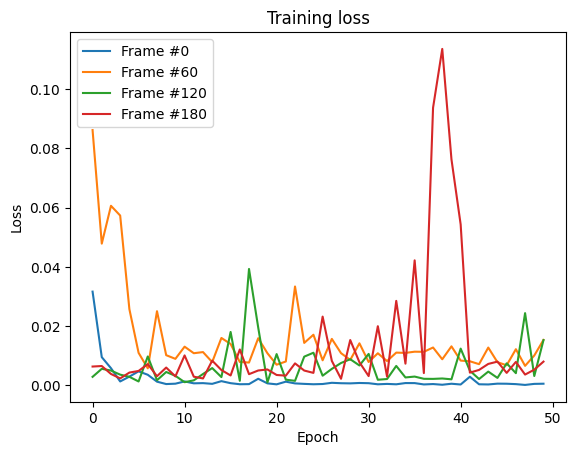

In [11]:
plt.tight_layout()
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

for i, loss in enumerate(loss_all):
    plt.plot(loss, label='Frame #{}'.format(i*skip_size))
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

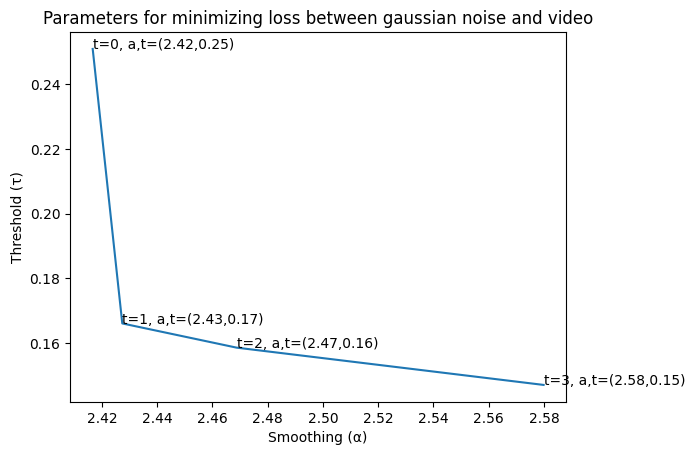

In [12]:
a, t = np.array(params).T
plt.plot(a, t)
for i, (x,y) in enumerate(params):
    plt.annotate('t={}, a,t=({:.02f},{:.02f})'.format(i,x,y), xy=(x,y))
plt.title('Parameters for minimizing loss between gaussian noise and video')
plt.xlabel('Smoothing (α)')
plt.ylabel('Threshold (τ)')
plt.show

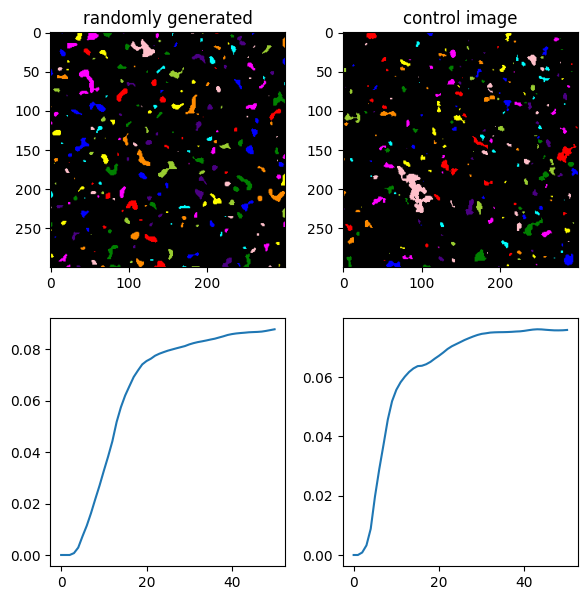

In [13]:
noise = generate_noise(size, threshold=t[3], smooth=a[3])
F_noise, G_noise = analyse_image(noise, L=50)
F, G = analyse_image(im[3], L=50)

fig, ax = plt.subplots(2,2, figsize=(6,6))
plt.tight_layout()

ax[0,0].set_title('randomly generated')
ax[0,0].imshow(label2rgb(noise))
ax[1,0].plot(F_noise/G_noise)

ax[0,1].set_title('control image')
ax[0,1].imshow(label2rgb(im[3]))
ax[1,1].plot(F/G)
plt.show()

In [14]:
# def stochastic_loss(thresh, disk):
#     noise = generate_noise(size=size, threshold=thresh, disk_size=disk, amount=4)
#     res_list = stochastic_analyse_video(noise, L=50)
#     return np.mean([(i[0] - y[i[1]])**2 for i in res_list])